In [72]:
import pickle
import random
import pandas as pd
import sympy as sp
from scipy.integrate import solve_ivp
import os
import json
import numpy as np
from scipy.spatial import KDTree


with open(r'D:\ucl\pyssem\scenario-properties.pkl', 'rb') as file:
    scenario_properties = pickle.load(file)

In [73]:
scenario_properties.full_drag

Matrix([
[-155214656923.387*Su_260kg_1 + 156898007337.069*Su_260kg_2, -694842321494.874*Su_473kg_1 + 702378098930.566*Su_473kg_2, -5385501432041.67*N_0.00141372kg_1 + 5443908841774.79*N_0.00141372kg_2, -2343214920581.54*N_0.567kg_1 + 2368627802870.44*N_0.567kg_2,  -155214656929.82*N_260kg_1 + 156898007343.571*N_260kg_2, -694842321584.656*N_473kg_1 + 702378099021.321*N_473kg_2, -308352274098.656*B_1 + 311696448794.863*B_2],
[-156898007337.069*Su_260kg_2 + 158563487880.536*Su_260kg_3, -702378098930.566*Su_473kg_2 + 709833879139.511*Su_473kg_3, -5443908841774.79*N_0.00141372kg_2 + 5501696218493.41*N_0.00141372kg_3, -2368627802870.44*N_0.567kg_2 + 2393770910723.45*N_0.567kg_3, -156898007343.571*N_260kg_2 + 158563487887.108*N_260kg_3,  -702378099021.321*N_473kg_2 + 709833879231.23*N_473kg_3, -311696448794.863*B_2 + 315005122880.318*B_3],
[-158563487880.536*Su_260kg_3 + 160211655853.559*Su_260kg_4, -709833879139.511*Su_473kg_3 + 717212156959.973*Su_473kg_4, -5501696218493.41*N_0.00141372kg_3

In [88]:
def preload_density_data(file_path):
    with open(file_path, 'r') as file:
        density_data = json.load(file)
    return density_data

def precompute_date_mapping(start_date, end_date, num_points=101):
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    total_days = (end_date - start_date).days
    dates = [start_date + pd.to_timedelta(i / (num_points - 1) * total_days, unit='d') for i in range(num_points)]
    date_mapping = [date.strftime('%Y-%m') for date in dates]
    return date_mapping

def precompute_nearest_altitudes(available_altitudes, max_query=2000, resolution=1):
    altitude_tree = KDTree(np.array(available_altitudes).reshape(-1, 1))
    altitude_mapping = {}
    for alt in range(0, max_query + resolution, resolution):
        _, idx = altitude_tree.query([[alt]])
        nearest_alt = available_altitudes[idx[0]]
        altitude_mapping[alt] = nearest_alt
    return altitude_mapping

def JB2008_dens_func(t, h, density_data, date_mapping, nearest_altitude_mapping):
    """
    Calculate density at various altitudes based on a percentage through a time range
    using precomputed data for efficiency.

    :param t: Time in days from the start of the simulation.
    :param h: List of altitudes for which densities are required.
    :param density_data: Preloaded density data.
    :param date_mapping: Precomputed date mapping.
    :param nearest_altitude_mapping: Precomputed nearest altitude mapping.
    :return: List of densities corresponding to each altitude in h.
    """
    # Normalize t to be between 0 and the length of date_mapping - 1
    num_dates = len(date_mapping)
    total_simulation_time = scenario_properties.simulation_duration  # in days
    t_normalized = t / total_simulation_time * (num_dates - 1)
    
    # Find the two nearest indices and their corresponding dates
    t_index_floor = int(np.floor(t_normalized))
    t_index_ceil = int(np.ceil(t_normalized))

    if t_index_ceil >= num_dates:
        t_index_ceil = num_dates - 1

    date_floor = date_mapping[t_index_floor]
    date_ceil = date_mapping[t_index_ceil]

    # Interpolation weight
    if t_index_floor == t_index_ceil:
        weight = 1
    else:
        weight = (t_normalized - t_index_floor) / (t_index_ceil - t_index_floor)

    # Get density values for the floor and ceil dates
    density_values_floor = []
    density_values_ceil = []
    for alt in h:
        query_alt = min(alt, max(nearest_altitude_mapping.keys()))
        nearest_alt = nearest_altitude_mapping[query_alt]

        density_floor = density_data[date_floor][str(nearest_alt)]
        density_ceil = density_data[date_ceil][str(nearest_alt)]

        density_values_floor.append(density_floor)
        density_values_ceil.append(density_ceil)

    # Interpolate between the floor and ceil density values
    density_values = np.array(density_values_floor) * (1 - weight) + np.array(density_values_ceil) * weight

    return density_values

In [74]:
# Lambdafiying the equations
symbols = scenario_properties.all_symbolic_vars

equations_flattened = [scenario_properties.equations[i, j] for j in range(scenario_properties.equations.cols) for i in range(scenario_properties.equations.rows)]
drag_upper_flattened = [scenario_properties.drag_term_upper[i, j] for j in range(scenario_properties.drag_term_upper.cols) for i in range(scenario_properties.drag_term_upper.rows)]
drag_current_flattened = [scenario_properties.drag_term_cur[i, j] for j in range(scenario_properties.drag_term_cur.cols) for i in range(scenario_properties.drag_term_cur.rows)]

# Convert equations to lambda functions
equations = [sp.lambdify(symbols, eq, 'numpy') for eq in equations_flattened]
drag_upper_lamd = [sp.lambdify(symbols, eq, 'numpy') for eq in drag_upper_flattened]
drag_cur_lamd = [sp.lambdify(symbols, eq, 'numpy') for eq in drag_current_flattened]

full_lambda_flattened = []

for i in range(len(scenario_properties.full_lambda)):
    if scenario_properties.full_lambda[i] is not None:
        full_lambda_flattened.extend(scenario_properties.full_lambda[i])
    else:
        # Append None to the list, length of scenario_properties.n_shells
        full_lambda_flattened.extend([None]*scenario_properties.n_shells)

In [42]:
scenario_properties.time_dep_density = True

In [89]:
x0_flattened = scenario_properties.x0.T.values.flatten()

rho_vals = []
time_vals = []

def population_shell(t, N, full_lambda, equations, times):
    print(f"Time: {t}")
    dN_dt = np.zeros_like(N)
    
    if scenario_properties.time_dep_density:
        # Get density values for the current time step
        rho = JB2008_dens_func(t, scenario_properties.R0_km, density_data, date_mapping, nearest_altitude_mapping)
        # print(f"Density at time {t}: {rho}")

        # Add the 10th value of rho to rho_vals for plotting
        rho_vals.append(rho[10])
        time_vals.append(t)
        
        # Extend rho for each species within each shell
        rho_full = np.repeat(rho, scenario_properties.species_length)

        num_shells = len(rho)
        species_per_shell = scenario_properties.species_length
        
        for i in range(len(N)):
            shell_index = i // species_per_shell
            species_index = i % species_per_shell
            
            current_drag = drag_cur_lamd[i](*N) * rho_full[shell_index]
            upper_drag = drag_upper_lamd[i](*N) * rho_full[shell_index + 1] if shell_index < num_shells - 1 else 0
            
            print(f"Index: {i}, Shell: {shell_index}, Species: {species_index}, Rho: {rho_full[shell_index]}")
            print(f"Current drag: {current_drag}, Upper drag: {upper_drag}")
            
            dN_dt[i] += current_drag * 0.0001
            if shell_index < num_shells - 1:
                dN_dt[i] += upper_drag * 0.0001

            if full_lambda[i] is not None:
                increase = np.interp(t, times, full_lambda[i])
                dN_dt[i] += 0 if np.isnan(increase) else increase

            dN_dt[i] += equations[i](*N)

    return dN_dt


output = solve_ivp(population_shell, [scenario_properties.scen_times[0], scenario_properties.scen_times[-1]], x0_flattened, 
                    args=(full_lambda_flattened, equations, scenario_properties.scen_times), 
                    t_eval=scenario_properties.scen_times, method='BDF')

Time: 0.0
Index: 0, Shell: 0, Species: 0, Rho: 5.702479798915825e-13
Current drag: -195.34343394419912, Upper drag: 3.399889325853175
Index: 1, Shell: 0, Species: 1, Rho: 5.702479798915825e-13
Current drag: -3.399889325853175, Upper drag: 3.164717802695368
Index: 2, Shell: 0, Species: 2, Rho: 5.702479798915825e-13
Current drag: -3.164717802695368, Upper drag: 1.0963244772669294
Index: 3, Shell: 0, Species: 3, Rho: 5.702479798915825e-13
Current drag: -1.0963244772669294, Upper drag: 33.77838401974999
Index: 4, Shell: 0, Species: 4, Rho: 5.702479798915825e-13
Current drag: -33.77838401974999, Upper drag: 0.0
Index: 5, Shell: 0, Species: 5, Rho: 5.702479798915825e-13
Current drag: -0.0, Upper drag: 1.7883497995379354
Index: 6, Shell: 0, Species: 6, Rho: 5.702479798915825e-13
Current drag: -1.7883497995379354, Upper drag: 0.0
Index: 7, Shell: 1, Species: 0, Rho: 5.702479798915825e-13
Current drag: -0.0, Upper drag: 0.0
Index: 8, Shell: 1, Species: 1, Rho: 5.702479798915825e-13
Current drag

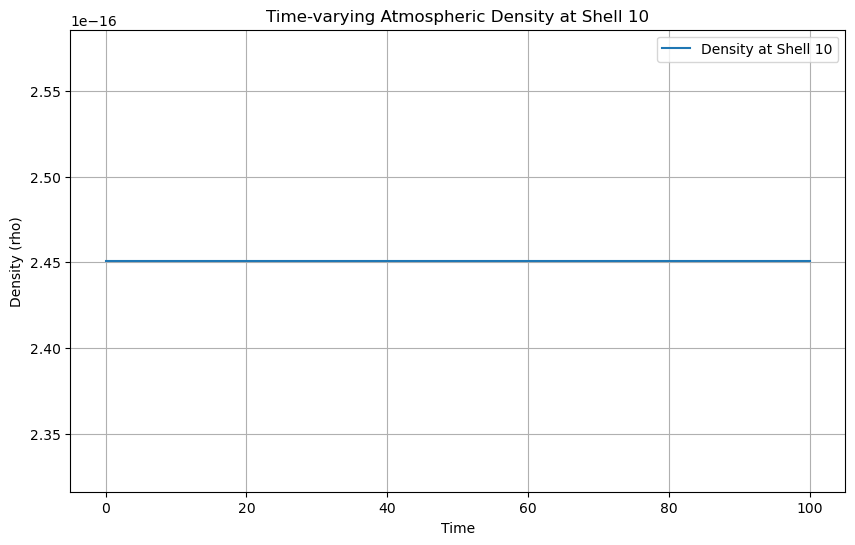

In [90]:
plt.figure(figsize=(10, 6))
plt.plot(time_vals, rho_vals, label='Density at Shell 10')
plt.xlabel('Time')
plt.ylabel('Density (rho)')
plt.title('Time-varying Atmospheric Density at Shell 10')
plt.legend()
plt.grid(True)
plt.show()

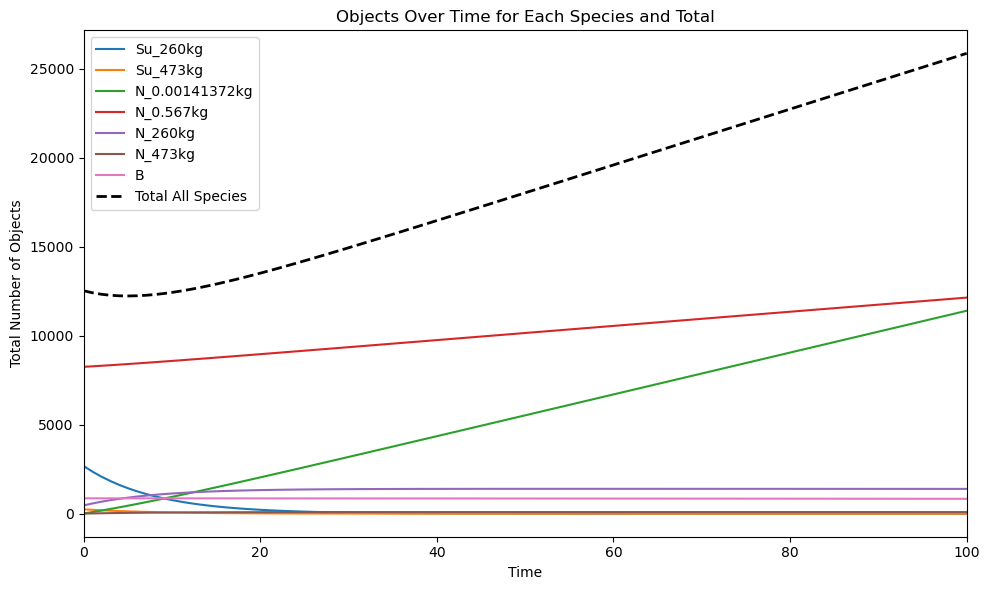

In [81]:
# Assuming scenario_properties.species_names is available
import matplotlib.pyplot as plt # type: ignore
species_names = scenario_properties.species_names
# output = scenario_properties.output

plt.figure(figsize=(10, 6))

# Assuming output.y's shape is (n_variables, n_time_points) and is ordered by species
num_species = scenario_properties.species_length
num_shells = scenario_properties.n_shells

# Initialize an array to hold the total number of objects at each time point
total_objects_all_species = np.zeros_like(output.t)

# Sum and plot for each species, using species names for labels
for i in range(num_species):
    start_idx = i * num_shells
    end_idx = start_idx + num_shells
    total_objects_per_species = np.sum(output.y[start_idx:end_idx, :], axis=0)  # Sum along the vertical axis
    plt.plot(output.t, total_objects_per_species, label=f'{species_names[i]}')
    
    # Add to the total objects count
    total_objects_all_species += total_objects_per_species

# Plot the total sum line
plt.plot(output.t, total_objects_all_species, label='Total All Species', color='k', linewidth=2, linestyle='--')

plt.xlabel('Time')
plt.ylabel('Total Number of Objects')
plt.title('Objects Over Time for Each Species and Total')
plt.xlim(0, max(output.t))


plt.legend()
plt.tight_layout()
plt.show()